# NN for cars classification

In [52]:
import numpy as np
import os
import gdown
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [53]:
TRAIN_PATH = 'cars'
TEST_PATH = 'cars_test'

TEST_SPLIT = 0.1
VAL_SPLIT = 0.2

IMG_WIDTH = 128
IMG_HEIGHT = 64
IMG_CHANNELS = 3

ROTATION_RANGE = 8
WIDTH_SHIFT_RANGE = 0.15
HEIGHT_SHIFT_RANGE = 0.15
ZOOM_RANGE = 0.15
BRIGHTNESS_RANGE = (0.7, 0.12)
HORIZONTAL_FLIP = True

EPOCHS = 60
OPTIMIZER = Adam(learning_rate = 0.0001)
BATCH_SIZE = 24

In [54]:
gdown.download('https://storage.googleapis.com/datasets_ai/Base/5_Conv/middle_fmr.zip', None, quiet=True)

'middle_fmr.zip'

In [55]:
!unzip -qo 'middle_fmr' -d {TRAIN_PATH}

In [56]:
CLASS_LIST = sorted(os.listdir(TRAIN_PATH))
CLASS_COUNT = len(CLASS_LIST)
print(CLASS_LIST, CLASS_COUNT)

['Ferrari', 'Mercedes', 'Renault'] 3


In [57]:
os.mkdir(TEST_PATH)
train_count = 0
test_count = 0

for class_name in CLASS_LIST:
    class_path = f'{TRAIN_PATH}/{class_name}'
    test_path = f'{TEST_PATH}/{class_name}'
    class_files = os.listdir(class_path)
    class_files_count = len(class_files)
    os.mkdir(test_path)
    test_files_count = int(class_files_count * TEST_SPLIT)
    test_files = class_files[-test_files_count:]
    for f in test_files:
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_files_count
    test_count += test_files_count
    print(f'Размер класса {class_name}: {class_files_count} машин, для теста выделено файлов: {test_files_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса Ferrari: 1088 машин, для теста выделено файлов: 108
Размер класса Mercedes: 1161 машин, для теста выделено файлов: 116
Размер класса Renault: 1178 машин, для теста выделено файлов: 117
Общий размер базы: 3427, выделено для обучения: 3086, для теста: 341


In [58]:
!ls

Untitled.ipynb	cars  cars_test  middle_fmr.zip


In [59]:
ImageDataGenerator?

In [60]:
train_datagen = ImageDataGenerator(rescale = 1. / 255.,
                                  rotation_range = ROTATION_RANGE,
                                  width_shift_range = WIDTH_SHIFT_RANGE,
                                  height_shift_range = HEIGHT_SHIFT_RANGE,
                                  brightness_range = BRIGHTNESS_RANGE,
                                  zoom_range = ZOOM_RANGE,
                                  horizontal_flip = HORIZONTAL_FLIP,
                                  validation_split = VAL_SPLIT)

test_datagen = ImageDataGenerator(rescale = 1. / 255.)

In [61]:
train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                   target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                   batch_size = BATCH_SIZE,
                                                   class_mode = 'categorical',
                                                   shuffle = True,
                                                   subset = 'training')
validation_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                   target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                   batch_size = BATCH_SIZE,
                                                   class_mode = 'categorical',
                                                   shuffle = True,
                                                   subset = 'validation')
test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                                   target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                   batch_size = BATCH_SIZE,
                                                   class_mode = 'categorical',
                                                   shuffle = True)

Found 2469 images belonging to 3 classes.
Found 617 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


In [62]:
# Проверка формы данных
print(f'Формы данных тренировочной выборки: {train_generator[0][0].shape}, {train_generator[0][1].shape}, батчей: {len(train_generator)}')
print(f'Формы данных   проверочной выборки: {validation_generator[0][0].shape}, {validation_generator[0][1].shape}, батчей: {len(validation_generator)}')
print(f'Формы данных      тестовой выборки: {test_generator[0][0].shape}, {test_generator[0][1].shape}, батчей: {len(test_generator)}')

print()

# Проверка назначения меток классов
print(f'Метки классов тренировочной выборки: {train_generator.class_indices}')
print(f'Метки классов   проверочной выборки: {validation_generator.class_indices}')
print(f'Метки классов      тестовой выборки: {test_generator.class_indices}')

Формы данных тренировочной выборки: (24, 64, 128, 3), (24, 3), батчей: 103
Формы данных   проверочной выборки: (24, 64, 128, 3), (24, 3), батчей: 26
Формы данных      тестовой выборки: (24, 64, 128, 3), (24, 3), батчей: 15

Метки классов тренировочной выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}
Метки классов   проверочной выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}
Метки классов      тестовой выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}


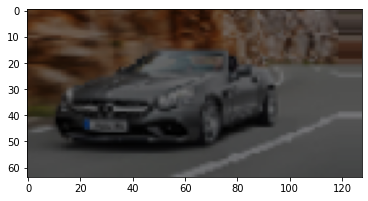

In [63]:
plt.imshow(train_generator[1][0][2])
plt.show()

In [64]:
def compile_train_model(model,
                       train_data,
                       val_data,
                       figsize = (20, 5),
                       epochs = EPOCHS,
                       optimizer = OPTIMIZER,
                       batch_size = BATCH_SIZE):
    model.compile(loss = 'categorical_crossentropy', optimizer = OPTIMIZER, metrics = ['accuracy'])
    model.summary()
    model.fit(train_data, epochs = epochs, batch_size = batch_size, validation_data = val_data)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'], 
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'], 
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'], 
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'], 
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

In [65]:
def eval_model(model, 
               x,
               y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)
               ):
    y_pred = model.predict(x)
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    cm = np.around(cm, cm_round)
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()
    fig.autofmt_xdate(rotation=45)
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()    

    print('-'*100)
    print(f'Нейросеть: {title}')

    for cls in range(len(class_labels)):
        cls_pred = np.argmax(cm[cls])
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [66]:
def compile_train_eval_model(model,
                             train_data,
                             val_data,
                             test_data,
                             class_labels=CLASS_LIST,
                             title='',
                             optimizer=OPTIMIZER,
                             epochs=EPOCHS,
                             batch_size=BATCH_SIZE,
                             graph_size=(20, 5),
                             cm_size=(10, 10)
                             ):
    
    compile_train_model(model, 
                        train_data,
                        val_data,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    eval_model(model, test_data[0][0], test_data[0][1], 
               class_labels=class_labels, 
               title=title,
               figsize=cm_size)

In [67]:
model_conv = Sequential()
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
model_conv.add(BatchNormalization())
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(Dropout(0.2))
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))
model_conv.add(Dropout(0.2))
model_conv.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))
model_conv.add(Dropout(0.2))
model_conv.add(Flatten())
model_conv.add(Dense(2048, activation='relu'))
model_conv.add(Dense(4096, activation='relu'))
model_conv.add(Dense(CLASS_COUNT, activation='softmax')) \

compile_train_eval_model(model_conv,
                         train_generator,
                         validation_generator,
                         test_generator,
                         class_labels=CLASS_LIST,
                         title='Сверточный классификатор')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 128, 256)      7168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 128, 256)      1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 128, 256)      590080    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 42, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 42, 256)       590080    
_________________________________________________________________
batch_normalization_2 (Batch (None, 21, 42, 256)       1024      
_________________________________________________________________
dropout (Dropout)            (None, 21, 42, 256)      

2022-02-14 11:21:04.015330: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60
 10/103 [=>............................] - ETA: 10:52 - loss: 3.2378 - accuracy: 0.3375

KeyboardInterrupt: 